In [72]:
!pip install kaggle


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
pip install kagglehub


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.24G/3.24G [04:37<00:00, 12.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\91902\.cache\kagglehub\datasets\crowww\a-large-scale-fish-dataset\versions\2


In [74]:
import os
import numpy as np
import pandas as pd

# Set the updated dataset path
DIR = r'C:\Users\91902\.cache\kagglehub\datasets\crowww\a-large-scale-fish-dataset\versions\2'

# Get subdirectories as classes
classes = [i for i in os.listdir(DIR) if '.' not in i]
print("Classes:", classes)

# Initialize lists for paths and labels
label = []
path = []

# Walk through the dataset directory
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            # Skip 'GT' directories if present
            if dirname.split()[-1] != 'GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname, filename))

# Create DataFrame
df = pd.DataFrame({'path': path, 'label': label})
print(df.head())


Classes: ['Fish_Dataset', 'NA_Fish_Dataset']
                                                path            label
0  C:\Users\91902\.cache\kagglehub\datasets\croww...  Black Sea Sprat
1  C:\Users\91902\.cache\kagglehub\datasets\croww...  Black Sea Sprat
2  C:\Users\91902\.cache\kagglehub\datasets\croww...  Black Sea Sprat
3  C:\Users\91902\.cache\kagglehub\datasets\croww...  Black Sea Sprat
4  C:\Users\91902\.cache\kagglehub\datasets\croww...  Black Sea Sprat


In [75]:
df.head()

,path,label
0,C:\Users\91902\.cache\kagglehub\datasets\croww...,Black Sea Sprat
1,C:\Users\91902\.cache\kagglehub\datasets\croww...,Black Sea Sprat
2,C:\Users\91902\.cache\kagglehub\datasets\croww...,Black Sea Sprat
3,C:\Users\91902\.cache\kagglehub\datasets\croww...,Black Sea Sprat
4,C:\Users\91902\.cache\kagglehub\datasets\croww...,Black Sea Sprat


In [76]:
df.path[1001]

'C:\\Users\\91902\\.cache\\kagglehub\\datasets\\crowww\\a-large-scale-fish-dataset\\versions\\2\\Fish_Dataset\\Fish_Dataset\\Gilt-Head Bream\\Gilt-Head Bream\\00002.png'

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9281 entries, 0 to 9280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9281 non-null   object
 1   label   9281 non-null   object
dtypes: object(2)
memory usage: 145.1+ KB


In [78]:
df['label'].value_counts()

label
Black Sea Sprat       1050
Red Mullet            1050
Shrimp                1050
Striped Red Mullet    1050
Trout                 1030
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Sea Bream         1000
Sea Bass              1000
Horse Mackerel          50
Gilt Head Bream          1
Name: count, dtype: int64

ValueError: num must be an integer with 1 <= num <= 9, not 10

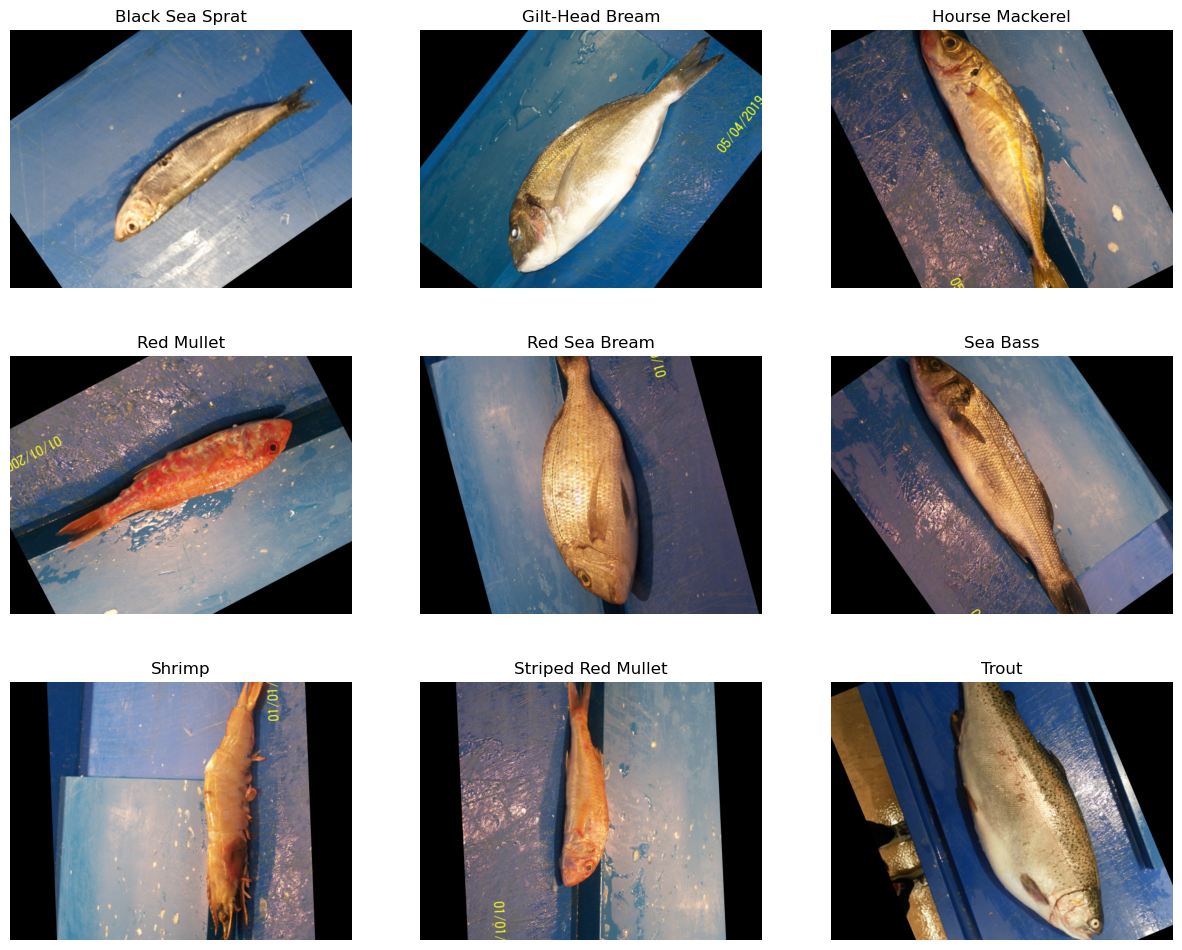

In [79]:
#displays one example image for each unique class in the dataset in a 3x3 grid
import matplotlib.pyplot as plt
import seaborn as sns
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [80]:
print(train_df.shape)
print(test_df.shape)

(7424, 2)
(1857, 2)


In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [82]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [83]:
#Here, 80% of 9000 is divided into train and 20% into test. From 80% train, 80% is used for training and 20% for validation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation settings for the training data
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    # Data augmentation settings
    rotation_range=20,        # Randomly rotate images by 20 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill in missing pixels after transformations
)

# For validation and test data, we typically don't use augmentation
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data generator (with augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Validation data generator (no augmentation, just preprocessing)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test data generator (no augmentation)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 5940 validated image filenames belonging to 10 classes.
Found 1484 validated image filenames belonging to 10 classes.
Found 1857 validated image filenames belonging to 11 classes.


In [84]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Horse Mackerel': 2,
 'Hourse Mackerel': 3,
 'Red Mullet': 4,
 'Red Sea Bream': 5,
 'Sea Bass': 6,
 'Shrimp': 7,
 'Striped Red Mullet': 8,
 'Trout': 9}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Horse Mackerel': 2,
 'Hourse Mackerel': 3,
 'Red Mullet': 4,
 'Red Sea Bream': 5,
 'Sea Bass': 6,
 'Shrimp': 7,
 'Striped Red Mullet': 8,
 'Trout': 9}

{'Black Sea Sprat': 0,
 'Gilt Head Bream': 1,
 'Gilt-Head Bream': 2,
 'Horse Mackerel': 3,
 'Hourse Mackerel': 4,
 'Red Mullet': 5,
 'Red Sea Bream': 6,
 'Sea Bass': 7,
 'Shrimp': 8,
 'Striped Red Mullet': 9,
 'Trout': 10}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


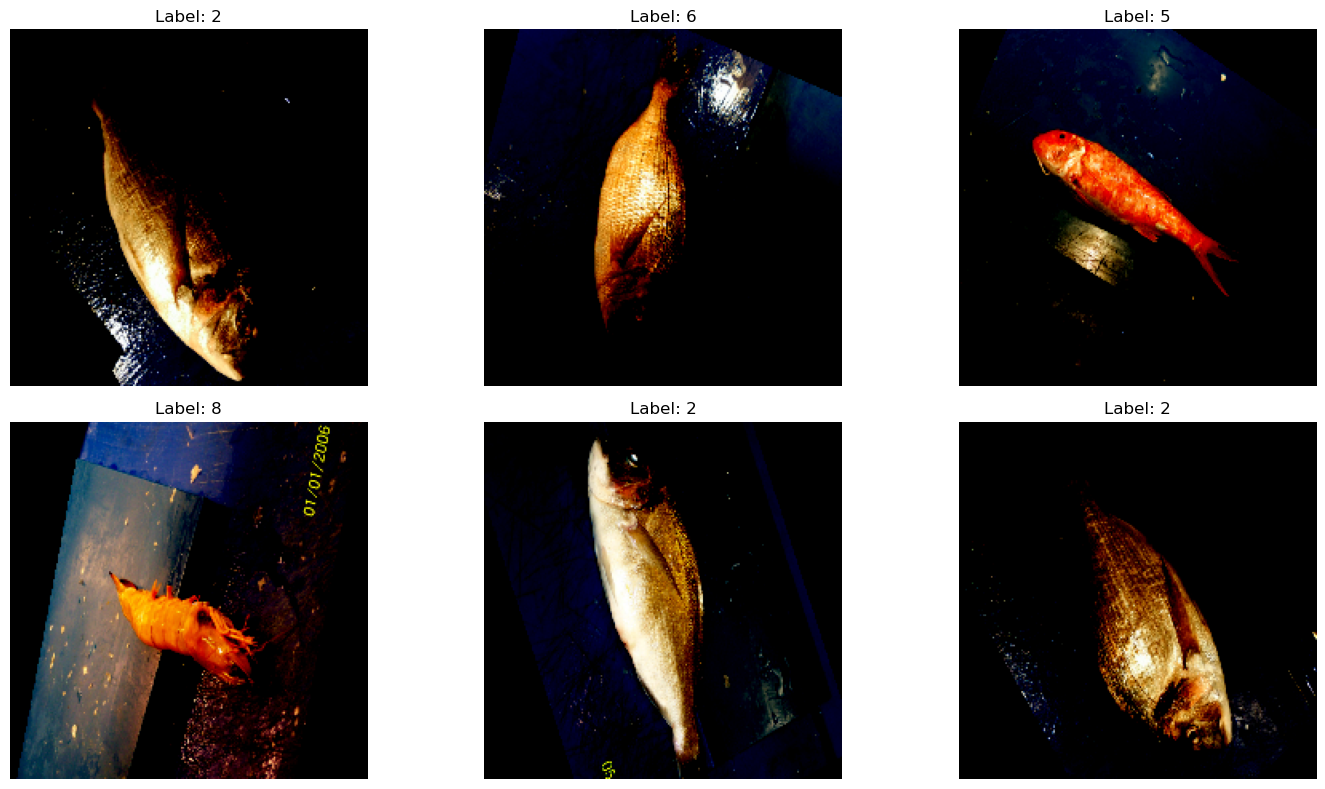

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
img, label = next(test_images)
for j in range(6):
    ax[j].imshow(img[j])
    ax[j].set_title(f'Label: {label[j].argmax()}')
    ax[j].axis('off')
plt.tight_layout()
plt.show()

In [86]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [87]:
from tensorflow.keras.layers import LeakyReLU, Dropout

inputs = pretrained_model.input

x = tf.keras.layers.Dense(64)(pretrained_model.output)
x = LeakyReLU(alpha=0.01)(x)

x = Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)

x = Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, validation_data=val_images, epochs=2)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\91902\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\91902\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\91902\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "C:\Users\91902\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\91902\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\91902\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\91902\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\91902\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\91902\AppData\Local\Temp\ipykernel_1912\155177935.py", line 22, in <module>

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy

  File "C:\Users\91902\anaconda3\Lib\site-packages\keras\src\backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,11] labels_size=[32,10]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_44478]

In [88]:
print("Classes found:", test_images.class_indices)




Classes found: {'Black Sea Sprat': 0, 'Gilt Head Bream': 1, 'Gilt-Head Bream': 2, 'Horse Mackerel': 3, 'Hourse Mackerel': 4, 'Red Mullet': 5, 'Red Sea Bream': 6, 'Sea Bass': 7, 'Shrimp': 8, 'Striped Red Mullet': 9, 'Trout': 10}


In [89]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 2.43198
Test Accuracy: 11.47%


In [90]:
#prediction for test images happen here
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

59/59 [==============================] - 35s 579ms/step


In [ ]:



#after prediction a new df is created with a new column pred and the predicted value from above is added into this new column
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
#re-indexes i.e 0 to n-1
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

In [ ]:
#wrong predictions
pred_df[pred_df['label']!=pred_df['pred']]

In [ ]:
model.save('model_mobilenetv2.keras')

In [ ]:




model = tf.keras.models.load_model('model_mobilenetv2.keras')

In [ ]:
def predict_image(image_path, model):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    import numpy as np

    # Load the image
    img = image.load_img(image_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict the class
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class = np.argmax(predictions, axis=1)

    # Map the class index to the label
    labels = {v: k for k, v in train_images.class_indices.items()}  # Assuming train_images.class_indices has the correct labels
    predicted_label = labels[predicted_class[0]]

    return predicted_label

# # Example usage:

    
# image_path = '/content/red-cooked-prawn-tiger-shrimp-260nw-745635706.webp'
# predicted_label = predict_image(image_path, model)
# print(f'Predicted Label: {predicted_label}')

In [ ]:
from sklearn.metrics import accuracy_score

# Get predictions
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

# True labels
true_labels = test_images.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()

# Plot Accuracy
plt.figure(figsize=(12, 6))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the classes on the test set
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

# True labels
true_labels = test_images.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming pred_df['label'] contains the true labels and pred_df['pred'] contains the predicted labels
report = classification_report(pred_df['label'], pred_df['pred'], target_names=list(test_images.class_indices.keys()))

print(report)